In [1]:
import sys
sys.path.append('../src')
from torch_utils import *
from pathlib import Path
from multilabel.evaluate import *
from harvest_data import EuropeanaAPI

from train_multilabel import *

# Single label

## Crossvalidation

In [ ]:
results_path = '/home/jcejudo/projects/image_classification/results/single_label/crossvalidation'

results_path = Path(results_path)
metrics_list = ['accuracy','precision','recall','f1',]

metrics_dict = {k:[] for k in metrics_list}
for split in results_path.iterdir():
    info_dict_path = split.joinpath('training_info.pth')
    info_dict = torch.load(info_dict_path)
    
    class_index_path = split.joinpath('class_index.json')
    
    with open(class_index_path,'r') as f:
        class_index_dict = json.load(f)
        class_index_dict = {int(i):v for i,v in class_index_dict.items()}

    for metric in metrics_list:
        metrics_dict[metric].append(info_dict[metric+'_test'])
               
for k,v in metrics_dict.items():
    mean = sum(v)/len(v)
    std = np.std(np.array(v))
    print(f'{k}: {mean:.3f}+-{std:.3f}')

In [ ]:
# to do: loop for crossvalidation

In [ ]:

results_path = '/home/jcejudo/projects/image_classification/results/single_label/crossvalidation'

cat_metrics = None

for split in Path(results_path).iterdir():
    test_pred_path = split.joinpath('test_pred.json')
    class_index_path = split.joinpath('class_index.json')
    
    if not test_pred_path.is_file():
        continue

    with open(class_index_path,'r') as f:
        class_index_dict = json.load(f)
        class_index_dict = {int(i):v for i,v in class_index_dict.items()}

    with open(test_pred_path,'r') as f:
        test_pred = json.load(f)

    from sklearn.metrics import classification_report
    target_names = [class_index_dict[k] for k in class_index_dict.keys()]

    report =  classification_report(test_pred['ground_truth'], test_pred['predictions'], target_names=target_names,output_dict=True) 

    if cat_metrics is None:
        cat_metrics = {k:{'precision':[],'recall':[],'f1-score':[],} for k in target_names}

    for category in cat_metrics.keys():
        cat_metrics[category]['precision'].append(report[category]['precision'])
        cat_metrics[category]['recall'].append(report[category]['recall'])
        cat_metrics[category]['f1-score'].append(report[category]['f1-score'])

        
for cat in cat_metrics.keys():
    cat_metrics[cat]['precision'] = {'mean':np.mean(cat_metrics[cat]['precision']),'std':np.std(cat_metrics[cat]['precision'])}
    cat_metrics[cat]['recall'] = {'mean':np.mean(cat_metrics[cat]['recall']),'std':np.std(cat_metrics[cat]['recall'])}
    cat_metrics[cat]['f1-score'] = {'mean':np.mean(cat_metrics[cat]['f1-score']),'std':np.std(cat_metrics[cat]['f1-score'])}

from tabulate import tabulate

table_list = [['category','precision','recall','f1-score']]


for k in cat_metrics.keys():
    prec_mean = cat_metrics[k]['precision']['mean']
    prec_std = cat_metrics[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'

    recall_mean = cat_metrics[k]['recall']['mean']
    recall_std = cat_metrics[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'

    f1_mean = cat_metrics[k]['f1-score']['mean']
    f1_std = cat_metrics[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'

    table_list.append([k,prec_str,recall_str,f1_str])

print(tabulate(table_list))

In [ ]:
crossvalidation_metrics = cat_metrics

In [ ]:
# confusion matrix
confusion_matrix = info_dict['confusion_matrix_test']
labels = [class_index_dict[i] for i in range(confusion_matrix.shape[0])]
plot_conf_matrix(confusion_matrix,labels,font_scale=2.0,figsize=(15,15))

## Evaluation

In [ ]:
eval_results = '/home/jcejudo/projects/image_classification/results/single_label/evaluation'

results_path = Path(eval_results).joinpath('evaluation_results.pth')
metrics_dict = torch.load(results_path)
for k,v in metrics_dict.items():
    if k not in [ 'confusion_matrix','report']:
        mean = v['mean']
        std = v['std']
        print(f'{k}: {mean:.3f} +- {std:.3f}')
        
labels = [class_index_dict[i] for i in class_index_dict.keys()]

plot_conf_matrix(metrics_dict['confusion_matrix'],labels,font_scale=2.0,figsize=(15,15))

In [ ]:
from tabulate import tabulate

report = metrics_dict['report']
table_list = [['category','precision','recall','f1-score']]

prec_list = []
recall_list = []
f1_list = []

for k in report.keys():
    prec_mean = report[k]['precision']['mean']
    prec_std = report[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'
    
    recall_mean = report[k]['recall']['mean']
    recall_std = report[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'
    
    f1_mean = report[k]['f1-score']['mean']
    f1_std = report[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'
    
    table_list.append([k,prec_str,recall_str,f1_str])
    
    prec_list.append(prec_mean)
    recall_list.append(recall_mean)
    f1_list.append(f1_mean)
    
print(tabulate(table_list)) 

evaluation_metrics = report

In [ ]:


cat_list = []

precision_mean_list = []
recall_mean_list = []
f1_mean_list = []

precision_std_list = []
recall_std_list = []
f1_std_list = []

for k in crossvalidation_metrics.keys():
    cat_list.append(k)
    
    mean = crossvalidation_metrics[k]['precision']['mean']
    std = crossvalidation_metrics[k]['precision']['std']
    precision_mean_list.append(mean)
    precision_std_list.append(std)
    
    mean = crossvalidation_metrics[k]['recall']['mean']
    std = crossvalidation_metrics[k]['recall']['std']
    recall_mean_list.append(mean)
    recall_std_list.append(std)
    
    mean = crossvalidation_metrics[k]['f1-score']['mean']
    std = crossvalidation_metrics[k]['f1-score']['std']
    f1_mean_list.append(mean)
    f1_std_list.append(std)
    
    
crossvalidation_metrics = {
    'precision': {'mean':precision_mean_list,'std':precision_std_list},
    'recall': {'mean':recall_mean_list,'std':recall_std_list},
    'f1-score': {'mean':f1_mean_list,'std':f1_std_list},
}

precision_mean_list = []
recall_mean_list = []
f1_mean_list = []

precision_std_list = []
recall_std_list = []
f1_std_list = []

cat_list = []

for k in evaluation_metrics.keys():
    cat_list.append(k)
    
    mean = evaluation_metrics[k]['precision']['mean']
    std = evaluation_metrics[k]['precision']['std']
    precision_mean_list.append(mean)
    precision_std_list.append(std)
    
    mean = evaluation_metrics[k]['recall']['mean']
    std = evaluation_metrics[k]['recall']['std']
    recall_mean_list.append(mean)
    recall_std_list.append(std)
    
    mean = evaluation_metrics[k]['f1-score']['mean']
    std = evaluation_metrics[k]['f1-score']['std']
    f1_mean_list.append(mean)
    f1_std_list.append(std)
    
    
    
evaluation_metrics = {
    'precision': {'mean':precision_mean_list,'std':precision_std_list},
    'recall': {'mean':recall_mean_list,'std':recall_std_list},
    'f1-score': {'mean':f1_mean_list,'std':f1_std_list},
    }  


In [ ]:

        

figsize = (15,15)
log = False

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, sharex=True,figsize = figsize)

x_pos = np.arange(len(set(cat_list)))

print(x_pos.shape)

print(len(crossvalidation_metrics['precision']['mean']))
print(len(crossvalidation_metrics['precision']['std']))

cross_precision = ax1.bar([x-0.2 for x in x_pos], crossvalidation_metrics['precision']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['precision']['std'],label = 'crossvalidation')
eval_precision = ax1.bar([x for x in x_pos], evaluation_metrics['precision']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['precision']['std'])

#ax1.set_ylabel('Counts')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(cat_list)
ax1.set_title('precision')
ax1.tick_params(axis='x', rotation=90)


hbars = ax2.bar([x-0.2 for x in x_pos], crossvalidation_metrics['recall']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['recall']['std'])
hbars = ax2.bar([x for x in x_pos], evaluation_metrics['recall']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['recall']['std'])

#ax2.set_ylabel('Counts')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cat_list)
ax2.set_title('recall')
ax2.tick_params(axis='x', rotation=90)


hbars = ax3.bar([x-0.2 for x in x_pos], crossvalidation_metrics['f1-score']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['f1-score']['std'])
hbars = ax3.bar([x for x in x_pos], evaluation_metrics['f1-score']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['f1-score']['std'])

#ax3.set_ylabel('Counts')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cat_list)
ax3.set_title('f1-score')
ax3.tick_params(axis='x', rotation=90)


# to do: legend
handles = [cross_precision,eval_precision]
labels = ['crossvalidation','evaluation']

plt.legend(handles, labels)

plt.show()


In [ ]:
# to do: gradcam correctly classified, misclassified

results_path = '/home/jcejudo/projects/image_classification/results/single_label/crossvalidation'
data_dir = '/home/jcejudo/projects/image_classification/data/single_label/images_evaluation'

mode = 'incorrect'

N = 10

get_first = False

split_path = Path(results_path).joinpath('split_0')
with open(split_path.joinpath('conf.json'),'r') as f:
    conf = json.load(f)

input_size = conf['input_size']
resnet_size = conf['resnet_size']

df = path2DataFrame(data_dir)
X = df['file_path'].values
y = df['category'].values

X = X[:N]
y = y[:N]

print(X)

#load class_index dict
with open(split_path.joinpath('class_index.json'),'r') as f:
    class_index_dict = json.load(f)
    class_index_dict = {int(i):v for i,v in class_index_dict.items()}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(resnet_size,len(class_index_dict)).to(device)

#load model
model_path = split_path.joinpath('checkpoint.pth')
model.load_state_dict(torch.load(model_path))
model.eval()

transform = transforms.Compose([
transforms.Resize((input_size,input_size)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

cat_list = []

for img_path, label in zip(X,y):
    
    

    image = Image.open(img_path).convert('RGB')
        
    ID = Path(img_path).with_suffix('').name.replace('[ph]','/')
    URI = 'http://data.europeana.eu/item'+ID
    
    category_list, confidence_list, XAI_list = predict_grad_cam(
        model = model, 
        class_index_dict = class_index_dict,
        image = image,
        heatmap_layer = model.net.layer4[1].conv2, 
        transform = transform, 
        device = device, 
        thres = 0.1, 
        max_pred = 3)

    pred = category_list[0]
    conf = confidence_list[0]

    if pred == label and mode == 'correct' or pred != label and mode == 'incorrect':
        
        if get_first:
            if label in cat_list:
                continue
            else:
                cat_list.append(label)
            
        
        
        print(URI)
        print('ground truth: ',label)
        plot_grad_cam(
            image = image,
            category_list = category_list, 
            confidence_list = confidence_list,
            XAI_list = XAI_list,
            fontsize = 20,
            figsize = (20,20)
        )

        plt.show()
        
        

        print(50*'--')
        
    


# Multilabel

In [ ]:


results_path = '/home/jcejudo/projects/image_classification/results/multilabel/crossvalidation'
results_path = Path(results_path)

metrics_list = ['coverage','lrap','label_ranking_loss','ndcg_score','dcg_score']
metrics_list += ['acc','precision','recall','f1',]

metrics_dict = {k:[] for k in metrics_list}
for split in results_path.iterdir():
    info_dict_path = split.joinpath('training_info.pth')
    info_dict = torch.load(info_dict_path)
    
    class_index_path = split.joinpath('class_index.json')
    
    with open(class_index_path,'r') as f:
        class_index_dict = json.load(f)
        class_index_dict = {int(i):v for i,v in class_index_dict.items()}

    for metric in metrics_list:
        metrics_dict[metric].append(info_dict[metric+'_test'])
               
for k,v in metrics_dict.items():
    mean = sum(v)/len(v)
    std = np.std(np.array(v))
    print(f'{k}: {mean:.3f}+-{std:.3f}')

In [ ]:

cat_metrics = {k:{'precision':[],'recall':[],'f1-score':[],} for k in class_index_dict.values()}

for split in results_path.iterdir():
    info_dict_path = split.joinpath('training_info.pth')
    info_dict = torch.load(info_dict_path)
    
    class_index_path = split.joinpath('class_index.json')

    for cm,v in zip(info_dict['confusion_matrix_test'],class_index_dict.values()):

        TN = float(cm[0,0])
        TP = float(cm[1,1])
        FP = float(cm[0,1])
        FN = float(cm[1,0])

        try:
            recall = TP/(TP+FN)
        except:
            recall = 0
        try:
            precision = TP/(TP+FP)
        except:
            precision = 0
            
        try:
            f1 = 2*TP/(2*TP+FP+FN)
        except:
            f1 = 0
            
        cat_metrics[v]['precision'].append(precision)
        cat_metrics[v]['recall'].append(recall)
        cat_metrics[v]['f1-score'].append(f1)
        

for k in cat_metrics.keys():
    cat_metrics[k]['precision'] = {'mean':np.mean(cat_metrics[k]['precision']),'std':np.std(cat_metrics[k]['precision'])}
    cat_metrics[k]['recall'] = {'mean':np.mean(cat_metrics[k]['recall']),'std':np.std(cat_metrics[k]['recall'])}
    cat_metrics[k]['f1-score'] = {'mean':np.mean(cat_metrics[k]['f1-score']),'std':np.std(cat_metrics[k]['f1-score'])}

from tabulate import tabulate

table_list = [['category','precision','recall','f1-score']]


for k in cat_metrics.keys():
    prec_mean = cat_metrics[k]['precision']['mean']
    prec_std = cat_metrics[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'
    
    recall_mean = cat_metrics[k]['recall']['mean']
    recall_std = cat_metrics[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'
    
    f1_mean = cat_metrics[k]['f1-score']['mean']
    f1_std = cat_metrics[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'
    
    table_list.append([k,prec_str,recall_str,f1_str])

print(tabulate(table_list))



In [ ]:
crossvalidation_metrics = cat_metrics

In [ ]:
#confusion matrix
for cm,v in zip(info_dict['confusion_matrix_test'],class_index_dict.values()):
    labels = ['False','True']
    plot_conf_matrix(cm,labels,font_scale=2.0,figsize=(5,5),title=v)

## Evaluation

In [ ]:
eval_results = '/home/jcejudo/projects/image_classification/results/multilabel/evaluation'

results_path = Path(eval_results).joinpath('evaluation_results.pth')
metrics_dict = torch.load(results_path)

for k,v in metrics_dict.items():
    if k not in ['confusion_matrix','report']:
        mean = metrics_dict[k]['mean']
        std = metrics_dict[k]['std']
        print(f'{k}: {mean:.3f}+-{std:.3f}')
        

from tabulate import tabulate

report = metrics_dict['report']
table_list = [['category','precision','recall','f1-score']]

prec_list = []
recall_list = []
f1_list = []

for k in report.keys():
    prec_mean = report[k]['precision']['mean']
    prec_std = report[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'
    
    recall_mean = report[k]['recall']['mean']
    recall_std = report[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'
    
    f1_mean = report[k]['f1-score']['mean']
    f1_std = report[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'
    
    table_list.append([k,prec_str,recall_str,f1_str])
    
    prec_list.append(prec_mean)
    recall_list.append(recall_mean)
    f1_list.append(f1_mean)
    
print(tabulate(table_list)) 

In [ ]:
evaluation_metrics = report

In [ ]:
for k,cm in metrics_dict['confusion_matrix'].items():
    labels = ['False','True']
    plot_conf_matrix(cm.astype(int),labels,font_scale=2.0,figsize=(5,5),title=k)

In [ ]:


cat_list = []

precision_mean_list = []
recall_mean_list = []
f1_mean_list = []

precision_std_list = []
recall_std_list = []
f1_std_list = []

for k in crossvalidation_metrics.keys():
    cat_list.append(k)
    
    mean = crossvalidation_metrics[k]['precision']['mean']
    std = crossvalidation_metrics[k]['precision']['std']
    precision_mean_list.append(mean)
    precision_std_list.append(std)
    
    mean = crossvalidation_metrics[k]['recall']['mean']
    std = crossvalidation_metrics[k]['recall']['std']
    recall_mean_list.append(mean)
    recall_std_list.append(std)
    
    mean = crossvalidation_metrics[k]['f1-score']['mean']
    std = crossvalidation_metrics[k]['f1-score']['std']
    f1_mean_list.append(mean)
    f1_std_list.append(std)
    
    
crossvalidation_metrics = {
    'precision': {'mean':precision_mean_list,'std':precision_std_list},
    'recall': {'mean':recall_mean_list,'std':recall_std_list},
    'f1-score': {'mean':f1_mean_list,'std':f1_std_list},
}

precision_mean_list = []
recall_mean_list = []
f1_mean_list = []

precision_std_list = []
recall_std_list = []
f1_std_list = []

cat_list = []

for k in evaluation_metrics.keys():
    cat_list.append(k)
    
    mean = evaluation_metrics[k]['precision']['mean']
    std = evaluation_metrics[k]['precision']['std']
    precision_mean_list.append(mean)
    precision_std_list.append(std)
    
    mean = evaluation_metrics[k]['recall']['mean']
    std = evaluation_metrics[k]['recall']['std']
    recall_mean_list.append(mean)
    recall_std_list.append(std)
    
    mean = evaluation_metrics[k]['f1-score']['mean']
    std = evaluation_metrics[k]['f1-score']['std']
    f1_mean_list.append(mean)
    f1_std_list.append(std)
    
    
    
evaluation_metrics = {
    'precision': {'mean':precision_mean_list,'std':precision_std_list},
    'recall': {'mean':recall_mean_list,'std':recall_std_list},
    'f1-score': {'mean':f1_mean_list,'std':f1_std_list},
    }  


        

figsize = (15,15)
log = False

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, sharex=True,figsize = figsize)

x_pos = np.arange(len(set(cat_list)))

print(x_pos.shape)

print(len(crossvalidation_metrics['precision']['mean']))
print(len(crossvalidation_metrics['precision']['std']))

cross_precision = ax1.bar([x-0.2 for x in x_pos], crossvalidation_metrics['precision']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['precision']['std'],label = 'crossvalidation')
eval_precision = ax1.bar([x for x in x_pos], evaluation_metrics['precision']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['precision']['std'])

#ax1.set_ylabel('Counts')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(cat_list)
ax1.set_title('precision')
ax1.tick_params(axis='x', rotation=90)


hbars = ax2.bar([x-0.2 for x in x_pos], crossvalidation_metrics['recall']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['recall']['std'])
hbars = ax2.bar([x for x in x_pos], evaluation_metrics['recall']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['recall']['std'])

#ax2.set_ylabel('Counts')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cat_list)
ax2.set_title('recall')
ax2.tick_params(axis='x', rotation=90)


hbars = ax3.bar([x-0.2 for x in x_pos], crossvalidation_metrics['f1-score']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['f1-score']['std'])
hbars = ax3.bar([x for x in x_pos], evaluation_metrics['f1-score']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['f1-score']['std'])

#ax3.set_ylabel('Counts')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cat_list)
ax3.set_title('f1-score')
ax3.tick_params(axis='x', rotation=90)


# to do: legend
handles = [cross_precision,eval_precision]
labels = ['crossvalidation','evaluation']

plt.legend(handles, labels)

plt.show()


In [ ]:
# gradcam 

N =80

results_path = '/home/jcejudo/projects/image_classification/results/multilabel/crossvalidation'
data_dir = '/home/jcejudo/projects/image_classification/data/multilabel/images_evaluation'
eval_annotations = '/home/jcejudo/projects/image_classification/data/multilabel/eval_multilabel_with_URL.csv'

data_dir = Path(data_dir)

split_path = Path(results_path).joinpath('split_0')
with open(split_path.joinpath('conf.json'),'r') as f:
    conf = json.load(f)

input_size = conf['input_size']
resnet_size = conf['resnet_size']

#load class_index dict
with open(split_path.joinpath('class_index.json'),'r') as f:
    class_index_dict = json.load(f)
    class_index_dict = {int(i):v for i,v in class_index_dict.items()}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model,class_index_dict = load_multilabel_model(split_path,device,resnet_size = resnet_size)

df = pd.read_csv(eval_annotations)
#df = df.dropna()
#filter images in df contained in data_path
imgs_list = list(data_dir.iterdir())
df['filepath'] = df['ID'].apply(lambda x:data_dir.joinpath(id_to_filename(x)+'.jpg'))
df = df.loc[df['filepath'].apply(lambda x: Path(x) in imgs_list)]

X = df['filepath'].values
y = df['category'].values

X = X[:N]
y = y[:N]

model.eval()

transform = transforms.Compose([
transforms.Resize((input_size,input_size)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for img_path, label in zip(X,y):

    image = Image.open(img_path).convert('RGB')
        
    ID = Path(img_path).with_suffix('').name.replace('[ph]','/')
    URI = 'http://data.europeana.eu/item'+ID
    
    category_list, confidence_list, XAI_list = predict_grad_cam(
        model = model, 
        class_index_dict = class_index_dict,
        image = image,
        heatmap_layer = model.net.layer4[1].conv2, 
        transform = transform, 
        device = device, 
        thres = 0.5, 
        max_pred = 3)

    print(URI)
    print('ground truth: ',label)
    plot_grad_cam(
        image = image,
        category_list = category_list, 
        confidence_list = confidence_list,
        XAI_list = XAI_list,
        fontsize = 20,
        figsize = (20,20)
    )

    plt.show()

    print(50*'--')

# Labelstudio

## Crossvalidation

In [ ]:
results_path = '/home/jcejudo/projects/image_classification/results/multilabel/labelstudio_crossvalidation'
results_path = Path(results_path)

metrics_list = ['coverage','lrap','label_ranking_loss','ndcg_score','dcg_score']
metrics_list += ['acc','precision','recall','f1',]

metrics_dict = {k:[] for k in metrics_list}
for split in results_path.iterdir():
    info_dict_path = split.joinpath('training_info.pth')
    info_dict = torch.load(info_dict_path)
    
    class_index_path = split.joinpath('class_index.json')
    
    with open(class_index_path,'r') as f:
        class_index_dict = json.load(f)
        class_index_dict = {int(i):v for i,v in class_index_dict.items()}

    for metric in metrics_list:
        metrics_dict[metric].append(info_dict[metric+'_test'])
               
for k,v in metrics_dict.items():
    mean = sum(v)/len(v)
    std = np.std(np.array(v))
    print(f'{k}: {mean:.3f}+-{std:.3f}')

In [ ]:

cat_metrics = {k:{'precision':[],'recall':[],'f1-score':[],} for k in class_index_dict.values()}

for split in results_path.iterdir():
    info_dict_path = split.joinpath('training_info.pth')
    info_dict = torch.load(info_dict_path)
    
    class_index_path = split.joinpath('class_index.json')

    for cm,v in zip(info_dict['confusion_matrix_test'],class_index_dict.values()):

        TN = float(cm[0,0])
        TP = float(cm[1,1])
        FP = float(cm[0,1])
        FN = float(cm[1,0])

        try:
            recall = TP/(TP+FN)
        except:
            recall = 0
        try:
            precision = TP/(TP+FP)
        except:
            precision = 0
            
        try:
            f1 = 2*TP/(2*TP+FP+FN)
        except:
            f1 = 0
            
        cat_metrics[v]['precision'].append(precision)
        cat_metrics[v]['recall'].append(recall)
        cat_metrics[v]['f1-score'].append(f1)
        

for k in cat_metrics.keys():
    cat_metrics[k]['precision'] = {'mean':np.mean(cat_metrics[k]['precision']),'std':np.std(cat_metrics[k]['precision'])}
    cat_metrics[k]['recall'] = {'mean':np.mean(cat_metrics[k]['recall']),'std':np.std(cat_metrics[k]['recall'])}
    cat_metrics[k]['f1-score'] = {'mean':np.mean(cat_metrics[k]['f1-score']),'std':np.std(cat_metrics[k]['f1-score'])}

from tabulate import tabulate

table_list = [['category','precision','recall','f1-score']]


for k in cat_metrics.keys():
    prec_mean = cat_metrics[k]['precision']['mean']
    prec_std = cat_metrics[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'
    
    recall_mean = cat_metrics[k]['recall']['mean']
    recall_std = cat_metrics[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'
    
    f1_mean = cat_metrics[k]['f1-score']['mean']
    f1_std = cat_metrics[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'
    
    table_list.append([k,prec_str,recall_str,f1_str])

print(tabulate(table_list))



In [ ]:
crossvalidation_metrics = cat_metrics

In [ ]:
#confusion matrix
for cm,v in zip(info_dict['confusion_matrix_test'],class_index_dict.values()):
    labels = ['False','True']
    plot_conf_matrix(cm,labels,font_scale=2.0,figsize=(5,5),title=v)

## Evaluation

In [ ]:
eval_results = '/home/jcejudo/projects/image_classification/results/multilabel/evaluation_labelstudio/'

results_path = Path(eval_results).joinpath('evaluation_results.pth')
metrics_dict = torch.load(results_path)

for k,v in metrics_dict.items():
    if k not in ['confusion_matrix','report']:
        mean = metrics_dict[k]['mean']
        std = metrics_dict[k]['std']
        print(f'{k}: {mean:.3f}+-{std:.3f}')
        

from tabulate import tabulate

report = metrics_dict['report']
table_list = [['category','precision','recall','f1-score']]

prec_list = []
recall_list = []
f1_list = []

for k in report.keys():
    prec_mean = report[k]['precision']['mean']
    prec_std = report[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'
    
    recall_mean = report[k]['recall']['mean']
    recall_std = report[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'
    
    f1_mean = report[k]['f1-score']['mean']
    f1_std = report[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'
    
    table_list.append([k,prec_str,recall_str,f1_str])
    
    prec_list.append(prec_mean)
    recall_list.append(recall_mean)
    f1_list.append(f1_mean)
    
print(tabulate(table_list)) 

In [ ]:
for k,cm in metrics_dict['confusion_matrix'].items():
    labels = ['False','True']
    plot_conf_matrix(cm.astype(int),labels,font_scale=2.0,figsize=(5,5),title=k)

In [ ]:
evaluation_metrics = report

In [ ]:


cat_list = []

precision_mean_list = []
recall_mean_list = []
f1_mean_list = []

precision_std_list = []
recall_std_list = []
f1_std_list = []

for k in crossvalidation_metrics.keys():
    cat_list.append(k)
    
    mean = crossvalidation_metrics[k]['precision']['mean']
    std = crossvalidation_metrics[k]['precision']['std']
    precision_mean_list.append(mean)
    precision_std_list.append(std)
    
    mean = crossvalidation_metrics[k]['recall']['mean']
    std = crossvalidation_metrics[k]['recall']['std']
    recall_mean_list.append(mean)
    recall_std_list.append(std)
    
    mean = crossvalidation_metrics[k]['f1-score']['mean']
    std = crossvalidation_metrics[k]['f1-score']['std']
    f1_mean_list.append(mean)
    f1_std_list.append(std)
    
    
crossvalidation_metrics = {
    'precision': {'mean':precision_mean_list,'std':precision_std_list},
    'recall': {'mean':recall_mean_list,'std':recall_std_list},
    'f1-score': {'mean':f1_mean_list,'std':f1_std_list},
}

precision_mean_list = []
recall_mean_list = []
f1_mean_list = []

precision_std_list = []
recall_std_list = []
f1_std_list = []

cat_list = []

for k in evaluation_metrics.keys():
    cat_list.append(k)
    
    mean = evaluation_metrics[k]['precision']['mean']
    std = evaluation_metrics[k]['precision']['std']
    precision_mean_list.append(mean)
    precision_std_list.append(std)
    
    mean = evaluation_metrics[k]['recall']['mean']
    std = evaluation_metrics[k]['recall']['std']
    recall_mean_list.append(mean)
    recall_std_list.append(std)
    
    mean = evaluation_metrics[k]['f1-score']['mean']
    std = evaluation_metrics[k]['f1-score']['std']
    f1_mean_list.append(mean)
    f1_std_list.append(std)
    
    
    
evaluation_metrics = {
    'precision': {'mean':precision_mean_list,'std':precision_std_list},
    'recall': {'mean':recall_mean_list,'std':recall_std_list},
    'f1-score': {'mean':f1_mean_list,'std':f1_std_list},
    }  


        

figsize = (15,15)
log = False

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, sharex=True,figsize = figsize)

x_pos = np.arange(len(set(cat_list)))

print(x_pos.shape)

print(len(crossvalidation_metrics['precision']['mean']))
print(len(crossvalidation_metrics['precision']['std']))

cross_precision = ax1.bar([x-0.2 for x in x_pos], crossvalidation_metrics['precision']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['precision']['std'],label = 'crossvalidation')
eval_precision = ax1.bar([x for x in x_pos], evaluation_metrics['precision']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['precision']['std'])

#ax1.set_ylabel('Counts')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(cat_list)
ax1.set_title('precision')
ax1.tick_params(axis='x', rotation=90)


hbars = ax2.bar([x-0.2 for x in x_pos], crossvalidation_metrics['recall']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['recall']['std'])
hbars = ax2.bar([x for x in x_pos], evaluation_metrics['recall']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['recall']['std'])

#ax2.set_ylabel('Counts')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cat_list)
ax2.set_title('recall')
ax2.tick_params(axis='x', rotation=90)


hbars = ax3.bar([x-0.2 for x in x_pos], crossvalidation_metrics['f1-score']['mean'], align='center',width=0.2,log=log, yerr = crossvalidation_metrics['f1-score']['std'])
hbars = ax3.bar([x for x in x_pos], evaluation_metrics['f1-score']['mean'], align='center',width=0.2,log=log, yerr = evaluation_metrics['f1-score']['std'])

#ax3.set_ylabel('Counts')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cat_list)
ax3.set_title('f1-score')
ax3.tick_params(axis='x', rotation=90)


# to do: legend
handles = [cross_precision,eval_precision]
labels = ['crossvalidation','evaluation']

plt.legend(handles, labels)

plt.show()


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/92070/BibliographicResource_1000126223712
ground truth:  building drawing


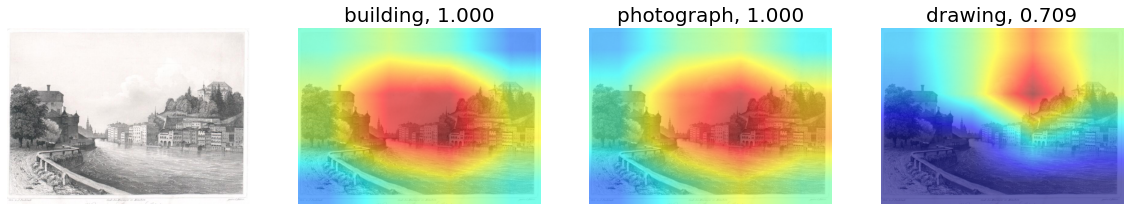

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/2020704/resource_document_rce_beeldbank_837866ec_3f22_11e4_9dc7_3b4bf4a0ed46_fcd2cc72_5c40_3737_f3d4_1b09b51fa7f6
ground truth:  building drawing


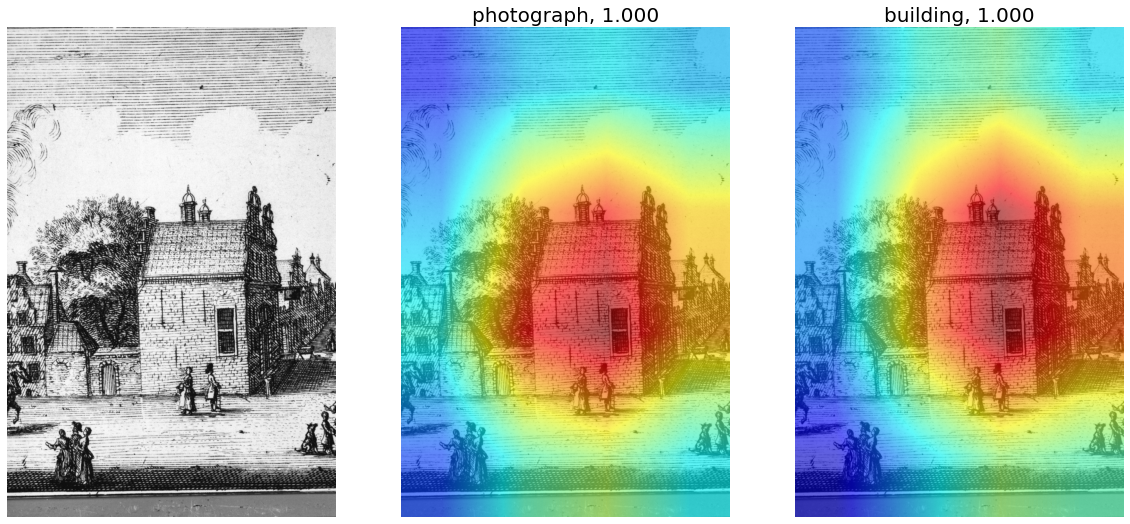

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/916121/S_OLM_photo_OLM_2004_80_1100
ground truth:  building furniture photograph


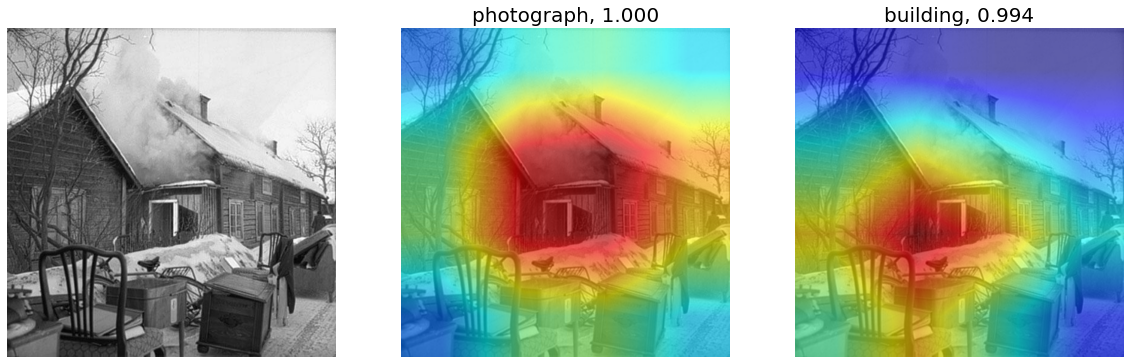

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/154/S_JVM_photo_JvmKDAF02705_02
ground truth:  building map photograph


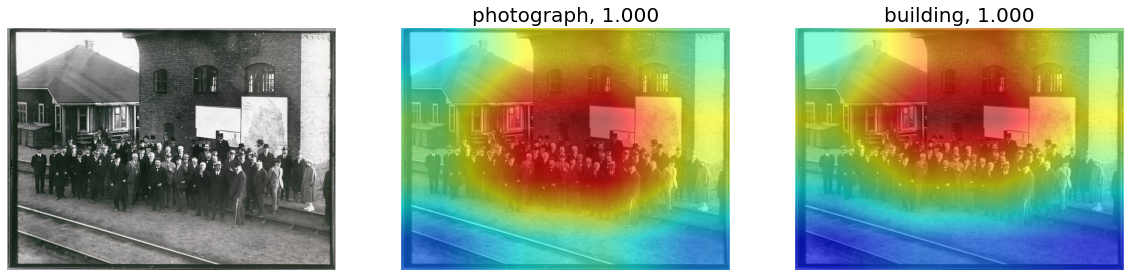

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/154/S_JVM_photo_JvmKDAA11666
ground truth:  building map postcard


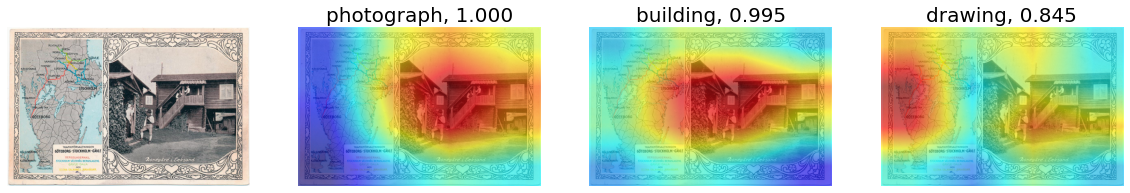

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/2022608/ROM_R_Fot_05434
ground truth:  building painting


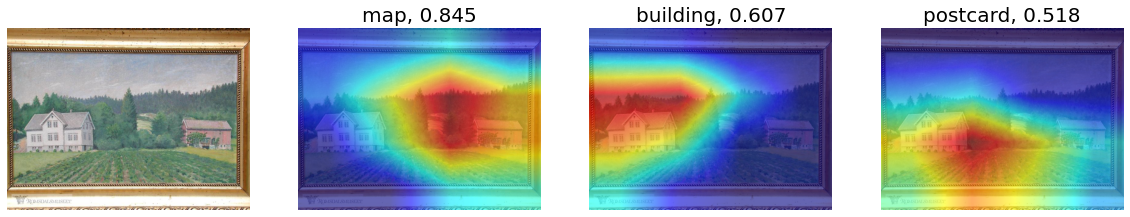

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/2022608/RMU_RMU_002938
ground truth:  building painting


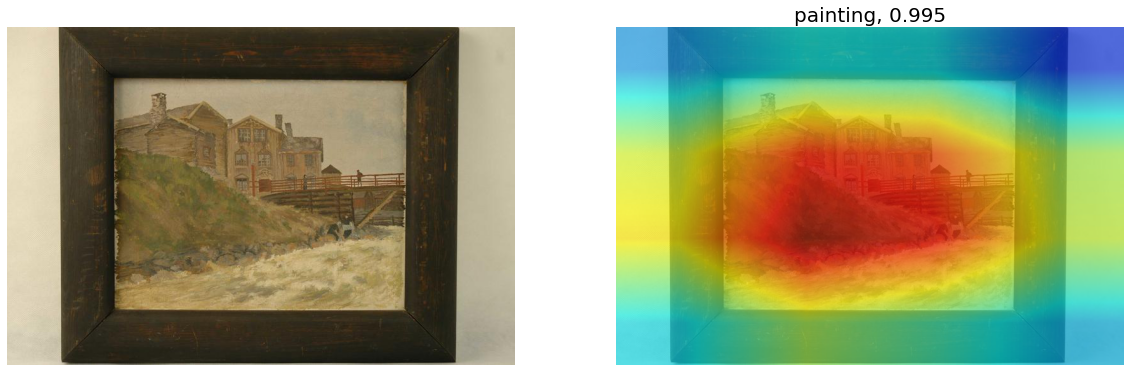

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/91659/sk_photo_SKAFOT0000177
ground truth:  building woodwork


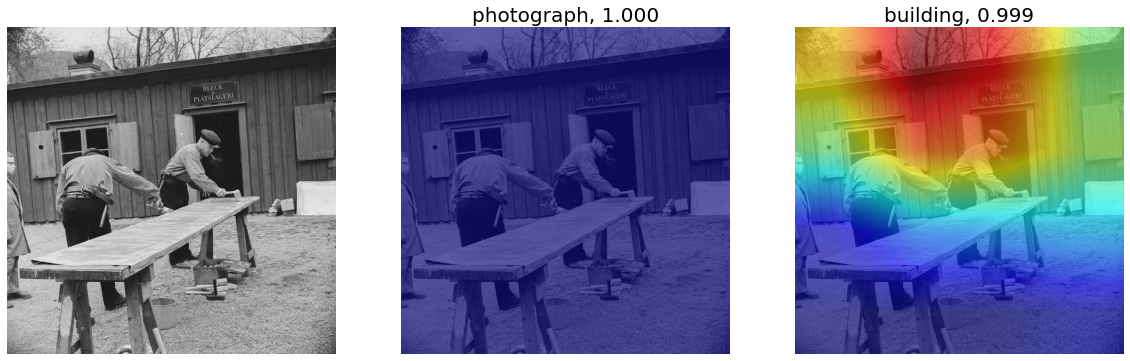

----------------------------------------------------------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
http://data.europeana.eu/item/2021008/_knp_140908
ground truth:  building woodwork


KeyboardInterrupt: 

In [2]:
# gradcam 

N =100

results_path = '/home/jcejudo/projects/image_classification/results/multilabel/labelstudio_crossvalidation'
data_dir = '/home/jcejudo/projects/image_classification/data/multilabel/images_evaluation'
eval_annotations = '/home/jcejudo/projects/image_classification/data/multilabel/eval_multilabel_with_URL.csv'

data_dir = Path(data_dir)

split_path = Path(results_path).joinpath('split_0')
with open(split_path.joinpath('conf.json'),'r') as f:
    conf = json.load(f)

input_size = conf['input_size']
resnet_size = conf['resnet_size']

#load class_index dict
with open(split_path.joinpath('class_index.json'),'r') as f:
    class_index_dict = json.load(f)
    class_index_dict = {int(i):v for i,v in class_index_dict.items()}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model,class_index_dict = load_multilabel_model(split_path,device,resnet_size = resnet_size)

df = pd.read_csv(eval_annotations)
#df = df.dropna()
#filter images in df contained in data_path
imgs_list = list(data_dir.iterdir())
df['filepath'] = df['ID'].apply(lambda x:data_dir.joinpath(id_to_filename(x)+'.jpg'))
df = df.loc[df['filepath'].apply(lambda x: Path(x) in imgs_list)]

X = df['filepath'].values
y = df['category'].values

X = X[:N]
y = y[:N]

model.eval()

transform = transforms.Compose([
transforms.Resize((input_size,input_size)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for img_path, label in zip(X,y):

    image = Image.open(img_path).convert('RGB')
        
    ID = Path(img_path).with_suffix('').name.replace('[ph]','/')
    URI = 'http://data.europeana.eu/item'+ID
    
    category_list, confidence_list, XAI_list = predict_grad_cam(
        model = model, 
        class_index_dict = class_index_dict,
        image = image,
        heatmap_layer = model.net.layer4[1].conv2, 
        transform = transform, 
        device = device, 
        thres = 0.5, 
        max_pred = 3)
    
    print(model.net.layer4[1].conv2)

    print(URI)
    print('ground truth: ',label)
    plot_grad_cam(
        image = image,
        category_list = category_list, 
        confidence_list = confidence_list,
        XAI_list = XAI_list,
        fontsize = 20,
        figsize = (20,20)
    )

    plt.show()

    print(50*'--')

In [ ]:
model.net.layer4[1].conv2

# Self supervised

In [10]:


eval_results = '/home/jcejudo/projects/image_classification/results/self_supervised_evaluation/'

results_path = Path(eval_results).joinpath('evaluation_results.pth')
metrics_dict = torch.load(results_path)

for k,v in metrics_dict.items():
    if k not in ['confusion_matrix','report']:
        mean = metrics_dict[k]['mean']
        std = metrics_dict[k]['std']
        print(f'{k}: {mean:.3f}+-{std:.3f}')
        

from tabulate import tabulate

report = metrics_dict['report']
table_list = [['category','precision','recall','f1-score']]

prec_list = []
recall_list = []
f1_list = []

for k in report.keys():
    prec_mean = report[k]['precision']['mean']
    prec_std = report[k]['precision']['std']
    prec_str = f'{prec_mean:.3f}+-{prec_std:.3f}'
    
    recall_mean = report[k]['recall']['mean']
    recall_std = report[k]['recall']['std']
    recall_str = f'{recall_mean:.3f}+-{recall_std:.3f}'
    
    f1_mean = report[k]['f1-score']['mean']
    f1_std = report[k]['f1-score']['std']
    f1_str = f'{f1_mean:.3f}+-{f1_std:.3f}'
    
    table_list.append([k,prec_str,recall_str,f1_str])
    
    prec_list.append(prec_mean)
    recall_list.append(recall_mean)
    f1_list.append(f1_mean)
    
print(tabulate(table_list)) 

acc: 0.019+-0.000
precision: 0.284+-0.000
recall: 0.437+-0.000
f1: 0.344+-0.000
coverage: 9.781+-0.000
lrap: 0.476+-0.000
label_ranking_loss: 0.265+-0.000
ndcg_score: 0.651+-0.000
dcg_score: 1.155+-0.000
-------------------  ------------  ------------  ------------
category             precision     recall        f1-score
archaeological_site  0.100+-0.000  0.750+-0.000  0.176+-0.000
building             0.273+-0.000  0.600+-0.000  0.375+-0.000
ceramics             0.096+-0.000  0.294+-0.000  0.145+-0.000
clothing             0.111+-0.000  0.111+-0.000  0.111+-0.000
costume_accessories  0.111+-0.000  0.111+-0.000  0.111+-0.000
drawing              0.429+-0.000  0.714+-0.000  0.536+-0.000
furniture            0.405+-0.000  0.366+-0.000  0.385+-0.000
inscription          0.000+-0.000  0.000+-0.000  0.000+-0.000
jewellery            0.190+-0.000  0.364+-0.000  0.250+-0.000
map                  0.000+-0.000  0.000+-0.000  0.000+-0.000
painting             0.250+-0.000  0.375+-0.000  0.300+-

In [6]:
# gradcam 

import sys

sys.path.append('/home/jcejudo/rd-img-classification-pilot/src/self_supervised')

from ss_models import *
from finetune_multilabel import *


N =10

results_path = '/home/jcejudo/projects/image_classification/results/self_supervised_evaluation/'
data_dir = '/home/jcejudo/projects/image_classification/data/multilabel/images_evaluation'
eval_annotations = '/home/jcejudo/projects/image_classification/data/multilabel/eval_multilabel_with_URL.csv'

data_dir = Path(data_dir)

split_path = Path(results_path)
with open(split_path.joinpath('conf.json'),'r') as f:
    conf = json.load(f)

input_size = conf['input_size']
resnet_size = conf['resnet_size']
ss_model = conf['ss_model']
benchmarking = conf['benchmarking']
num_ftrs = conf['num_ftrs']

#load class_index dict
with open(split_path.joinpath('class_index.json'),'r') as f:
    class_index_dict = json.load(f)
    class_index_dict = {int(i):v for i,v in class_index_dict.items()}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



#model,class_index_dict = load_multilabel_model(split_path,device,resnet_size = resnet_size)

n_categories = len(class_index_dict)

resnet_dict = {
    18: torchvision.models.resnet18(pretrained=False),
    34: torchvision.models.resnet34(pretrained=False),
    50: torchvision.models.resnet50(pretrained=False),
    101: torchvision.models.resnet101(pretrained=False),
}

backbone = resnet_dict[resnet_size]

if ss_model == 'byol':

    if benchmarking:
        model = BYOLModel_benchmarking(backbone,None,1,num_ftrs=num_ftrs,)

    else:
        model = BYOLModel(
            backbone,
            num_ftrs = num_ftrs,
            )

elif ss_model == 'moco':
    if benchmarking:
        model = MoCoModel_benchmarking(backbone,None,1,num_ftrs=num_ftrs,)

    else:
        model = MoCoModel(
            backbone,
            num_ftrs = num_ftrs,
            )



model = FineTuneModel(
    model,
    num_ftrs,
    n_categories
)

model = model.to(device)

print(model)

model.load_state_dict(torch.load(split_path.joinpath('checkpoint.pth')))


df = pd.read_csv(eval_annotations)
#df = df.dropna()
#filter images in df contained in data_path
imgs_list = list(data_dir.iterdir())
df['filepath'] = df['ID'].apply(lambda x:data_dir.joinpath(id_to_filename(x)+'.jpg'))
df = df.loc[df['filepath'].apply(lambda x: Path(x) in imgs_list)]

X = df['filepath'].values
y = df['category'].values

X = X[:N]
y = y[:N]

model.eval()

transform = transforms.Compose([
transforms.Resize((input_size,input_size)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for img_path, label in zip(X,y):

    image = Image.open(img_path).convert('RGB')
        
    ID = Path(img_path).with_suffix('').name.replace('[ph]','/')
    URI = 'http://data.europeana.eu/item'+ID
    
    category_list, confidence_list, XAI_list = predict_grad_cam(
        model = model, 
        class_index_dict = class_index_dict,
        image = image,
        heatmap_layer = model.net.resnet_moco.projection_head,
        transform = transform, 
        device = device, 
        thres = 0.5, 
        max_pred = 3)

    print(URI)
    print('ground truth: ',label)
    plot_grad_cam(
        image = image,
        category_list = category_list, 
        confidence_list = confidence_list,
        XAI_list = XAI_list,
        fontsize = 20,
        figsize = (20,20)
    )

    plt.show()

    print(50*'--')

FineTuneModel(
  (net): BYOLModel_benchmarking(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

TypeError: iteration over a 0-d array

In [4]:
model.net.backbone[4][0].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)